<a href="https://www.kaggle.com/code/mahfuzurmahimrahman/my-cnn-model-pytorch?scriptVersionId=172923668" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

### Data process

In [2]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])#std and mean for rgb imgs (imgnet)
])

In [3]:
dataset = ImageFolder(root='/kaggle/input/apparel-dataset', transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, val_size])

In [4]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

### Model


In [5]:
class ApparelModel(nn.Module):
    def __init__(self):
        super(ApparelModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 512, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.Conv2d(512, 256, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.Conv2d(256, 128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 14 * 14, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 37),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = ApparelModel()

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ApparelModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.2, inplace=False)
    (15): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (16): ReLU()
    (

### Train & Validation

In [8]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
train_recalls = []
train_f1_scores = []
val_precisions = []
val_recalls = []
val_f1_scores = []

for epoch in range(10):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/10', unit='batch'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
    train_losses.append(train_loss / len(train_loader))
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    with torch.no_grad():
        train_preds = torch.argmax(model(inputs), dim=1)
        train_precision = precision_score(labels.cpu(), train_preds.cpu(), average='micro')
        train_recall = recall_score(labels.cpu(), train_preds.cpu(), average='micro')
        train_f1 = f1_score(labels.cpu(), train_preds.cpu(), average='micro')
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1_scores.append(train_f1)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    for inputs, labels in tqdm(validation_loader, desc='Validation', unit='batch'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        val_loss += criterion(outputs, labels).item()
        _, predicted_val = torch.max(outputs, 1)
        total_val += labels.size(0)
        correct_val += (predicted_val == labels).sum().item()

    val_losses.append(val_loss / len(validation_loader))
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    with torch.no_grad():
        val_preds = torch.argmax(model(inputs), dim=1)
        val_precision = precision_score(labels.cpu(), val_preds.cpu(), average='micro')
        val_recall = recall_score(labels.cpu(), val_preds.cpu(), average='micro')
        val_f1 = f1_score(labels.cpu(), val_preds.cpu(), average='micro')
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1_scores.append(val_f1)
    

    print(f'Epoch {epoch + 1}, Validation Loss: {val_losses[-1]}, Validation Accuracy: {val_accuracies[-1]}')



# Save the trained model
torch.save(model.state_dict(), '/kaggle/working/model_checkpoint.pth')


Validation: 100%|██████████| 203/203 [00:57<00:00,  3.53batch/s]


Epoch 1, Validation Loss: 3.1266711885705956, Validation Accuracy: 0.551638837353123


Validation: 100%|██████████| 203/203 [00:47<00:00,  4.26batch/s]


Epoch 2, Validation Loss: 3.064940585291444, Validation Accuracy: 0.6091527520098948


Validation: 100%|██████████| 203/203 [00:47<00:00,  4.24batch/s]


Epoch 3, Validation Loss: 2.9470212189434783, Validation Accuracy: 0.7257266542980829


Validation: 100%|██████████| 203/203 [00:47<00:00,  4.31batch/s]


Epoch 4, Validation Loss: 2.915790802152286, Validation Accuracy: 0.7523191094619666


Validation: 100%|██████████| 203/203 [00:48<00:00,  4.16batch/s]


Epoch 5, Validation Loss: 2.9067997028087746, Validation Accuracy: 0.7606679035250464


Validation: 100%|██████████| 203/203 [00:47<00:00,  4.24batch/s]


Epoch 6, Validation Loss: 2.898996979144994, Validation Accuracy: 0.7705627705627706


Validation: 100%|██████████| 203/203 [00:47<00:00,  4.30batch/s]


Epoch 7, Validation Loss: 2.8861669143432467, Validation Accuracy: 0.7792207792207793


Validation: 100%|██████████| 203/203 [00:46<00:00,  4.32batch/s]


Epoch 8, Validation Loss: 2.8738681753280715, Validation Accuracy: 0.7878787878787878


Validation: 100%|██████████| 203/203 [00:46<00:00,  4.33batch/s]


Epoch 9, Validation Loss: 2.8777758875503916, Validation Accuracy: 0.7841682127396413


Validation: 100%|██████████| 203/203 [00:46<00:00,  4.32batch/s]

Epoch 10, Validation Loss: 2.8570539458044646, Validation Accuracy: 0.8042671614100185


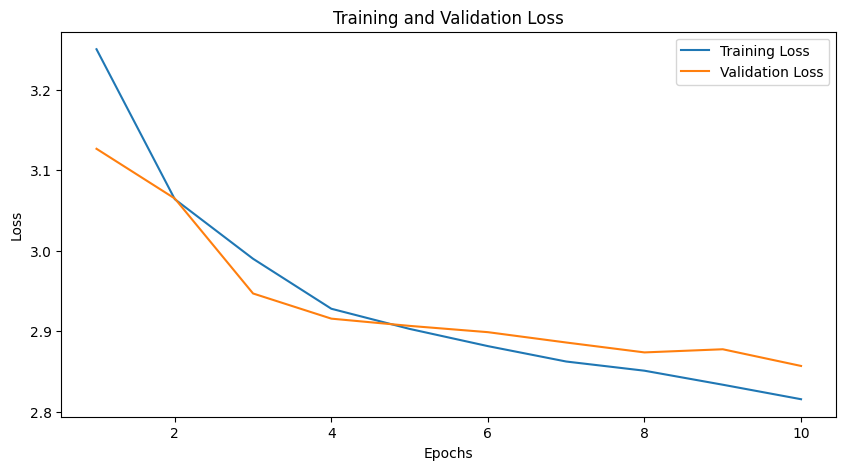

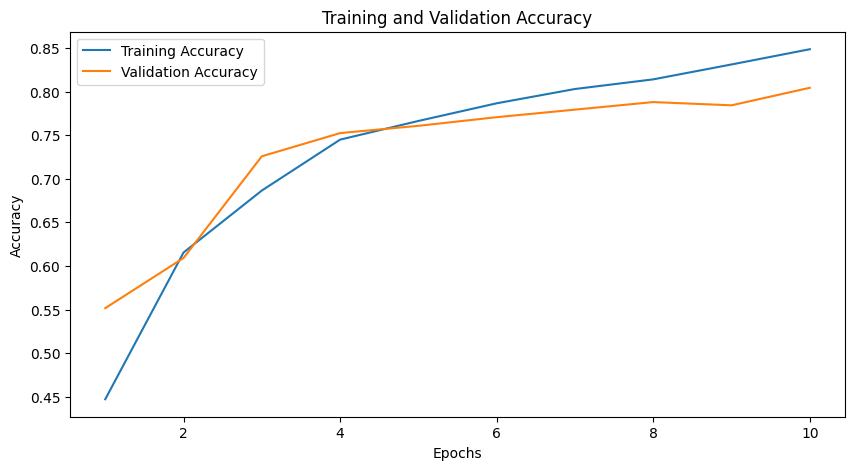

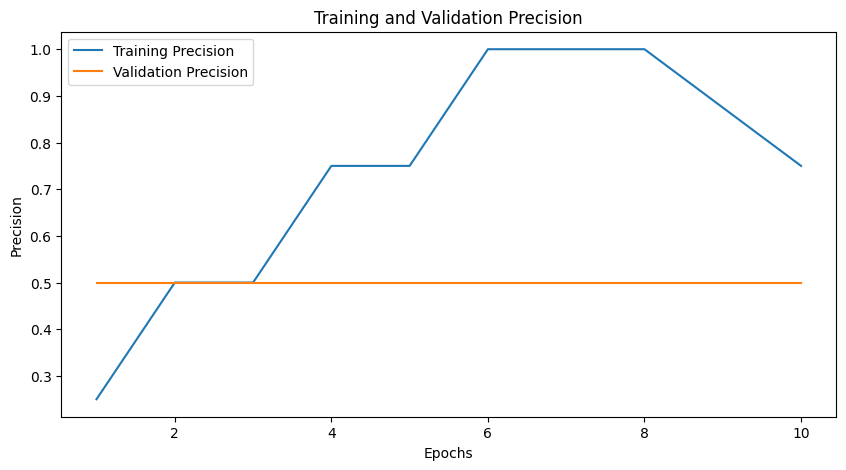

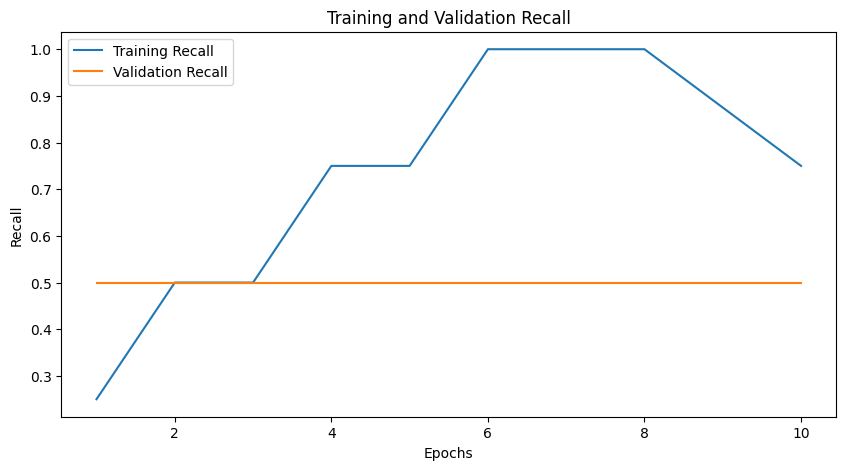

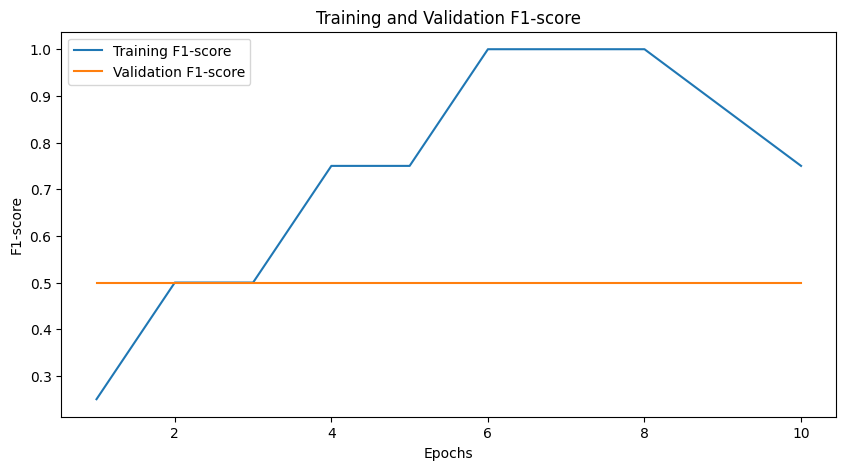

In [9]:
# Plotting
epochs = range(1, 11)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_precisions, label='Training Precision')
plt.plot(epochs, val_precisions, label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_recalls, label='Training Recall')
plt.plot(epochs, val_recalls, label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_f1_scores, label='Training F1-score')
plt.plot(epochs, val_f1_scores, label='Validation F1-score')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.title('Training and Validation F1-score')
plt.legend()
plt.show()

In [10]:
model = ApparelModel()
model.load_state_dict(torch.load('/kaggle/working/model_checkpoint.pth'))
model.eval()

ApparelModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.2, inplace=False)
    (15): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (16): ReLU()
    (